In [16]:
from google.colab import drive
drive.mount('/content/my')

Drive already mounted at /content/my; to attempt to forcibly remount, call drive.mount("/content/my", force_remount=True).


In [17]:
import sys
sys.path.append('/content/my/My Drive/BTC')

In [ ]:
import gym
import numpy as np
import random
import pandas as pd
import numpy as np
from environment_gym import trading_environment
from train import*
import matplotlib.pyplot as plt
import keras as ks
from keras.layers import Dense
import collections

Using TensorFlow backend.


Data preprocessing

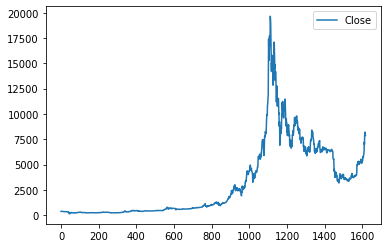

In [18]:
path = 'my/My Drive/BTC/'
data = pd.read_csv(path+'coinbase_daily.csv')
data = data[['Open','High','Low','Close','Volume BTC']]
market_data = data.values[::-1]
plt.plot(market_data[:,3])
plt.legend(['Close'])

Build a DQN

In [20]:
class DQN:
    def __init__(self, env):
        self.env = env
        self.pool_size=200
        self.learning_rate = 0.01
        self.epsilon = 0.1
        self.batch_size = 32
        self.alpha = 0.5
        self.gamma = 0.01
        self.experience_pool = collections.deque(maxlen=self.pool_size)
        self.model = self.build_model()
        self.target_model = self.model

    def build_model(self):
        model = ks.models.Sequential()
        input_size = self.env.observation_space.shape[0] * self.env.windows
        #input_size = 16
        output_size = 21

        model.add(Dense(100, input_dim=input_size, activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(output_size))

        model.compile(loss='mean_squared_error', optimizer=ks.optimizers.Adam(lr=self.learning_rate))
        return model

    def epsilon_greedy_action(self,state):
        rd = np.random.uniform()
        if rd >= self.epsilon:
            state = self.transfer_state_dim(state)
            act = np.argmax(self.model.predict(state))
        else:
            act = self.env.action_space.sample()
        return act

    def transfer_state_dim(self, state):#out put ndarray (1, 80)
        out = np.reshape(state, [1, state.shape[0] * state.shape[1]])
        return out

    def save_into_pool(self, state, act):
        state_next, rewards, done, info = self.env.step(act)
        new_sample = [state, act, rewards, state_next, done]
        self.experience_pool.append(new_sample)
        return state_next, rewards, done

    def initial_pool(self):
        i = 0
        while True:
            if i > self.pool_size:
                break
            state = self.env.reset()
            while True:
                i += 1
                act = self.env.action_space.sample()
                state_next, rewards, done, info = self.env.step(act)
                self.save_into_pool(state, act)
                state = state_next
                if done or i > self.pool_size:
                    break

    def sample_from_pool(self):
        training_samples = random.sample(self.experience_pool, self.batch_size)
        return training_samples

    def train_batch(self, training_samples):
        x_train = []
        y_train = []
        for sample in training_samples:
            state, act, reward, state_next, done = sample
            state = self.transfer_state_dim(state)
            x_train.append(state)
            state_next = self.transfer_state_dim(state_next)
            target = self.target_model.predict(state)
            if done:
                target[0][act] = reward
            else:
                target[0][act] = reward + self.gamma * np.max(self.target_model.predict(state_next))
            y_train.append(target)
        x_train = np.array(x_train)
        x_train = np.squeeze(x_train)
        y_train = np.array(y_train)
        y_train = np.squeeze(y_train)
        self.model.fit(x_train, y_train, epochs=50, verbose=0)

    def update_target_model(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        #self.target_model.set_weights(weights)#simply update by weights
        for i in range(len(weights)):
            target_weights[i] = (1 - self.alpha) * target_weights[i] + self.alpha * weights[i]
        self.target_model.set_weights(target_weights)

    def model_save(self, name):
        self.model.save(name)

Build a training function

In [31]:
def DQN_train(market_data, trails, iterations):
    
    initial_cash_balance = 10000
    initial_bt_balance = 0
    windows = 10
    env = trading_environment(market_data, windows=windows, initial_cash_balance=initial_cash_balance, initial_bt_balance=initial_bt_balance)
    DQN_agent = DQN(env)


    DQN_agent.initial_pool()
    print('initial pool finished')
    for trail in range(trails):
        print('trail', trail)
        state = env.reset()
        for iteration in range(iterations):
            print('iteration', iteration)
            act = DQN_agent.epsilon_greedy_action(state)#下一步
            state_next, rewards, done = DQN_agent.save_into_pool(state, act)#save into pool同时做一步step
            training_samples = DQN_agent.sample_from_pool()#sample from pool
            DQN_agent.train_batch(training_samples)#train batch
            if iteration%10==0:#update target NN every10 steps
                DQN_agent.update_target_model()
            state = state_next
            if done:
                break
        #DQN_agent.env.render()

    DQN_agent.model_save('BTC_DQN1')

Train a model with only one play trail and 10 steps in each trail.

In [32]:
DQN_train(market_data, 1, 100)

initial pool finished
trail 0
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
itera

See how this not well-trained model perform. Define a validation function.

In [33]:
def DQN_validation(market_data, path):

    initial_cash_balance = 10000
    initial_bt_balance = 0
    windows = 10

    start_time = 800
    env = trading_environment(market_data[start_time:], windows=windows, initial_cash_balance=initial_cash_balance, initial_bt_balance=initial_bt_balance)
    DQN_validate = DQN(env)
    DQN_validate.model = ks.models.load_model(path)

    trading_steps = 700
    state = DQN_validate.env.reset()

    DQN_validate.epsilon = 0# overwirte epsilon greedy
    for i in range(trading_steps):
        act = DQN_validate.epsilon_greedy_action(state)
        state_next, rewards, done, info = DQN_validate.env.step(act)
        state = state_next
    DQN_validate.env.render()

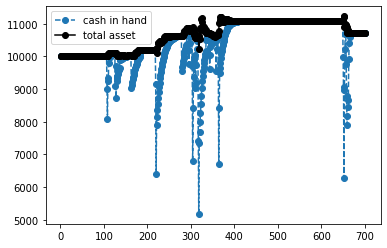

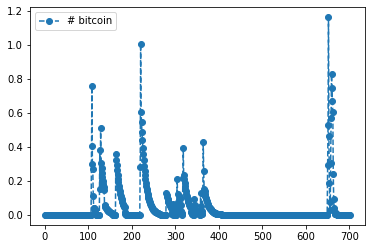

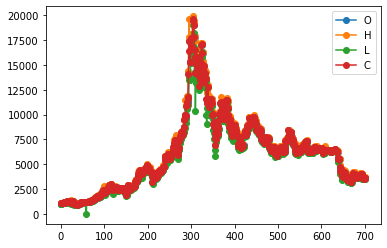

In [34]:
model_path = '/content/BTC_DQN1'
DQN_validation(market_data, model_path)

Basicallly this is like some random strategies, and it doesn't make much profit.

Now, I will train a model little bit longer with 5 trails each of which has 100 steps.

In [35]:
DQN_train(market_data, 5, 100)

initial pool finished
trail 0
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
itera

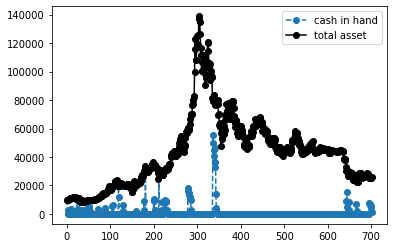

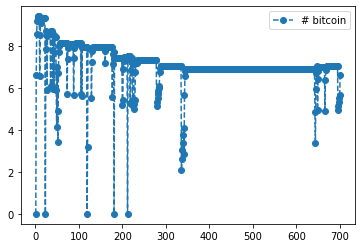

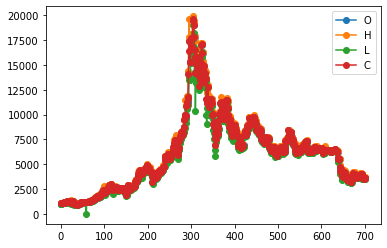

In [36]:
model_path = '/content/BTC_DQN1'
DQN_validation(market_data, model_path)

This one has already show the trend of doing a 'buy and hold' strategy as the number of bitcoin holds doesn't quite vibrate. As training even longer, the agent will give me a perfect 'buy and hold' strategy, which is undoubtedly good in bitcoin market.